### Test curvature calculations ###

In [1]:
import subprocess, shutil, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import vtu
from vtu import PyVtu
from ts_auto_wrapper import TSWrapper

In [2]:
ts=TSWrapper(Path("/opt/workspace/msc_project/cluster-trisurf"))
trisurf_test = Path('/opt/workspace/msc_project/simulations'
                    '/QA_tests/cluster_version/rework')

In [3]:
# children = lambda path: list(sorted(path.iterdir()))
# children(trisurf_test)

In [4]:
test_folder = trisurf_test/'egg_carton'/'linterp'
tape=None
extra_args = []
destroy_timesteps_at_end=False # destroy all timesteps after the test
timeout = 1000 # seconds to timeout for each `trisurf` test

In [5]:
tape="""In next cell (hidden)"""

In [6]:
tape = """
##################
## Trisurf Tape ##
##################

# a control file for the trisurf simulations
# $ are program control
# * are initialization only

####### Vesicle definitions ###########
# * nshell is a number of divisions of dipyramid
nshell=20
# $ dmax is the max. bond length (in units l_min)
dmax=1.7
# $ dmin_interspecies in the min. dist. between different vertex species (in units l_min)
dmin_interspecies=1.2
# $ max step size (in units l_min)
stepsize=0.15


#######  Cell definitions ############
# $ partition space to cells of 
nxmax=100
nymax=100
nzmax=100


####### Program Control ############
# $ how many MC sweeps between subsequent records of states to disk. 200000 is reasonable value
mcsweeps=1000
# $ how many initial mcsweeps*inititer MC sweeps before recording to disk?
inititer=0
# $ how many records do you want on the disk iteration are there in a run?
iterations=10


# $ do not write "ts_fprintf" statesments to stdout (for use in cluster)
quiet=false


######-----------------------------#######
###### Memrbane and CMC properties #######
######-----------------------------#######

# * bending rigidity of the membrane (in units kT)
xk0=20
# * xk2: Gaussian bending modulus
xk2=-20

# Each vertex is associated with a type (8 bit flag):
#   0x01 : bonding vertex              0x02 : active force vertex
#   0x04 : adhesive vertex             0x08 : anisotropic vertex
#   0x10 : (reserved for future use)   0x20 : vicsek vertex (correlated force)
#   0x40 : edge vertex (not used)      0x80 : ghost vertex (unnmoving) (must be ==type!)
#   Bare membrane vertices (default) are adhesive 0x04 (4), 
# CMC vertices are bonding, active, anisotropic, and correlated 0x2F (47)
# * number of CMC vertices (integer)
number_of_vertices_with_c0=0
# * c0/2 is spontaneous curvature. c0 is used as (c1+c1-c0)^2 in energy term (float)
c0=0.5
# * d0/2 is spontaneous deviator. d0 is used in shape tensor only (float)
# Mismatch = Curvature - c0/2*I - d0/2 sigma_z (i.e. the 1st and 2nd intrinsic curvatures are half the sum and half the difference )
d0=0.5

# $ curvature model (8 bit flag)
#   0x01 : calculate angle-sum gaussian curvature,  0x02 : calculate shape operator, 
#   0x04 : update director even in the old method.  0x08 : use shape operator energy rather than just save it
#   0x10 : use shape, but only for anisotropic.     0x20 : do not rotate director as a MC step
#   0x40 : disable old method (use shape op only)   0x80 : calculate angle sum only if kx2!=0
# example of important models: 
# 0: old method. 7: debug, save everything but use energy from old method. 35: parallel transport of directors only
curvature_model=15
# $ limit sharp edges by imposing the dihedral angle between triangle obeys cos(phi_ab)>X. -1 means no limit
max_dihedral_angle_cosine=-0.1

# * energy of bond between bonding vertices (float, positive value for attraction)
w=1.0
# $ bond model- vertex of bonding type bind with mean(w). (flag)
# 0x1: require type identity.   0x2: nematic interaction between anisotropic vtx
bond_model=0

# * direct force on active vertices (float)
F=1.0
# $ force_model- force on active type vertices. (integer flag)
#   0: force in normal direction
#   1: F proportional nonactive neigh, 2: F proportional nonconcave neigh
#   3: F=0 if any neigh is concave
#   16: Vicsek, direction aligend with connected neighbors up to radius,
#   17: 16, with weight 1/neighbor accoding to distance
force_model=0
# $ Vicsek: force direction is sum of own normal + (nearest neighbor normals * vicsek_strength)
# interaction strength parameter: Vicsek: weight of neighbors (float)
vicsek_strength=0.1
# $ interaction radius parameter: Vicsek: max. neighbor distance (integer)
vicsek_radius=4.0


######---------------------#######
###### Adhesion to surface #######
######---------------------#######

# $ Adhesion model (8 bit flag)
# energy of any adhesive vertex dx distance from the adhesion geometry 
# as long as distance is less than the cutoff (dx0)
#   0x01: step potential ad_w*(dx/dx0), 
#   0x02: parabolic ad_w*(1-(dx/dx0)^2)
#   0x04: y-anisotropy factor *exp(-y/scale)
adhesion_model=1
# $ type of adhesion geometry do you want (integer flag)
#   1: plane surface               f(r)=z-z0
#   2: spherical surface           f(r)=(x**2 + y**2 + (z-z0)**2)-r**2
#   3: cylindrical surface         f(r)=((z-z0)**2 + x**2)-r**2
#   4: plane-x sinosoidal surface    f(r)=z-(z0+rcos(x))
#   5: plane surface with adhesion spots  E*=factor*([x/scale-0.5]**2+[y/scale - 0.5]**2 less than r**2)
#   6: plane-xy sinosoidal surface    f(r)=z-(z0+rcos(x)cos(y))
adhesion_geometry=6
# $ potential range (float in lmin)
adhesion_cutoff=1
# $ position of the adhesive surface (float)
# bipyramid topmost is approx. z_max = 0.630877*nshell, so -z_max is a good guess
adhesion_z=-10
# $ radius of the sphere or cylinder.
adhesion_radius=2.0
# $ for sinosoidal, adhesion spot lattice, and y anisotropy (float)
adhesion_scale=2.0
# $ factor of adhesion on spots (float)
adhesion_factor=2.0
# * adhesion energy per vertex (float)
adhesion_strength=4.0

# $ Allow motion of center mass: default (0) reset vesicle to 0,0,0 every few time steps (bool) 
allow_center_mass_movement=0
# $ In active case, we need to apply an external force in the z-direction for overall force balance along z-direction, choose 1 if you want this, 0 otherwise (bool)
force_balance_along_z_axis=0


######-------------------------------------------#######
###### Pressure/volume/area/tension calculations #######
######-------------------------------------------#######

# all of these are program control (# $)

# $ Calculate p*dV energy contribution (bool)
pressure_switch=0
# $ pressure difference: p_inside - p_outside (in units kT/l_min^3):
pressure=0.0

# $ Volume constraint/energy (integer flag) 
#   0: disable constant volume
#   1: enable with additional vertex move {broken}
#   2: enable with epsvol range
#   3: enable parabolic potential (xkV0/2V0 (V-V0)^2)
#   4: enable reduced volume parabolic potential (xkV0/2 (V_red_eq-V/Vsph)^2)
volume_switch=0
constvolprecision=1e-14
# $ Rest volume. Set V0 less than 1 to determine volume from initial conditions (see constant_volume tag in .vtu files) (float)
V0=0
# $ volume modulus (float)
# needs some thinking: reasonable values depends on number of vertices N!
# reduced volume scaling is between 1/(N Sqrt(N)) and 1/N
xkV0=1.0
# $ reduce volume at equilibrium (between 0 and 1) (float)
Vr=1.0

# $ Area constraint/energy (integer flag) 
#   0: disable constant area, 
#   1: stretching of triangles
#   2: enable constant area with epsarea
#   3: enable parabolic potential (xkA0/2A0 (A-A0)^2)
area_switch=0
# $ Rest area, A0 less than 1 to determine area from initial conditions (see constant_area tag in .vtu files)  (float)
A0=0
# $ Stretching modulus (float)
xkA0=1.0


######------######
###### misc ######
######------######

####### Nucleus (inside the vesicle) ###########

# $ Radius and $ position of an impenetrable hard sphere inside the vesicle (float)
R_nucleus=0
R_nucleusX=0
R_nucleusY=0
R_nucleusZ=0

###### Plane confinement ############

# $ plane confinement; two plates between the substrate-vesicle system, upper plate in moving downwards untill plan_d, lower plate is stationary
plane_confinement_switch=0
# $ final plane distance (float in lmin)
plane_d=10
# $ plane to vesicle repulsion force while closing
plane_F=1.0

###### Spherical harmonics ###########

# $ If 0 then spherical harmonics are not calculated at all. (integer)
spherical_harmonics_coefficients=0


#####----------------------------------######
##### Polymer and filament decorations ######
#####----------------------------------######

####### Polymer (brush) definitions ###########
# * npoly is a number of polymers attached to npoly distinct vertices on vesicle
npoly=0
# * nmono is a number of monomers in each polymer
nmono=20
# $ Spring constant between monomers of the polymer
k_spring=800
# * set to 1 if half of the polymeres are inside the vesicle
internal_poly=0

####### Filament (inside the vesicle) definitions ###########
# * nfil is a number of filaments inside the vesicle
nfil=0
# * nfono is a number of monomers in each filament
nfono=3
# $ Persistence lenght of the filaments (in units l_min)
xi=100

##### no multiprocessing #######

"""

### Make a new folder if there isn't one ###

In [7]:
new_folder=None
if not test_folder:
    # make up some appropriate folder
    now = datetime.datetime.now()
    ret = subprocess.run(['git', 'status'],cwd=ts.path_to_trisurf,capture_output=True)
    branch = ret.stdout.decode().partition('On branch ')[-1].splitlines()[0].strip()
    new_folder = f'{now.year:04}_{now.month:02}_{now.day:02}_{branch}'
    test_folder = trisurf_test/new_folder
new_folder

In [8]:
if not test_folder.exists():
    test_folder.mkdir()
    test_folder.joinpath('test_results').mkdir()
elif new_folder is not None:
    raise ValueError(f'folder {test_folder} for today already exists: Rename or delete to run test')

### copy the tape to the new folder ###

In [8]:
if tape is None:
    shutil.copy(ts.path_to_trisurf/"src/tape",test_folder/"tape")
if type(tape) is str:
    with open(test_folder/"tape",'w') as f: f.write(tape);
else:
    shutil.copy(tape,test_folder/"tape")

## Check force from tape ##

In [13]:
# !cd {ts.path_to_trisurf} && make clean && make && cd -;
# print('done');

Making clean in src
make[1]: Entering directory '/opt/workspace/msc_project/cluster-trisurf/src'
 rm -f trisurf tsmeasure tspoststat
test -z "libtrisurf.la" || rm -f libtrisurf.la
rm -f ./so_locations
rm -rf .libs _libs
rm -f *.o
rm -f *.lo
make[1]: Leaving directory '/opt/workspace/msc_project/cluster-trisurf/src'
make[1]: Entering directory '/opt/workspace/msc_project/cluster-trisurf'
rm -rf .libs _libs
rm -f *.lo
make[1]: Leaving directory '/opt/workspace/msc_project/cluster-trisurf'
make  all-recursive
make[1]: Entering directory '/opt/workspace/msc_project/cluster-trisurf'
Making all in src
make[2]: Entering directory '/opt/workspace/msc_project/cluster-trisurf/src'
gcc -DHAVE_CONFIG_H -I. -I..  -I/usr/include/libxml2 -fgnu89-inline  -Wall  -DTS_VERSION=\"8a882d5-dirty\"  -O3 -ffast-math -flto=auto -MT main.o -MD -MP -MF .deps/main.Tpo -c -o main.o main.c
mv -f .deps/main.Tpo .deps/main.Po
/bin/bash ../libtool  --tag=CC   --mode=compile gcc -DHAVE_CONFIG_H -I. -I..  -I/usr/include

In [17]:
# ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", "--force-from-tape", "-c iterations=100,random_seed=1687249186", *extra_args],
#                      cwd=test_folder, timeout=timeout, capture_output=True)

In [18]:
# ret

CompletedProcess(args=[PosixPath('/opt/workspace/msc_project/cluster-trisurf/src/trisurf'), '--force-from-tape', '-c iterations=100,random_seed=1687249186'], returncode=0, stdout=b'[2023-06-21 16:31:52] TRISURF-NG v. 8a882d5-dirty, compiled on: Jun 21 2023 16:28:20.\n[2023-06-21 16:31:52] Programming done by: Samo Penic and Miha Fosnaric\n[2023-06-21 16:31:52] Released under terms of GPLv3\n[2023-06-21 16:31:52] Starting program...\n\n[2023-06-21 16:31:52] ************************************************\n[2023-06-21 16:31:52] **** Generating initial geometry from tape *****\n[2023-06-21 16:31:52] ************************************************\n\n[2023-06-21 16:31:52] Starting initial_distribution on vesicle with 20 shells!...\n[2023-06-21 16:31:52] initial_distribution finished!\n[2023-06-21 16:31:52] using debug curvature model 15 (use new energy): set to 7 to use the old energy method\n[2023-06-21 16:31:52] simulation seed = 1687249186\n[2023-06-21 16:31:52] Setting volume V0=8335

In [19]:
print(ret.stdout.decode())

[2023-06-21 16:31:52] TRISURF-NG v. 8a882d5-dirty, compiled on: Jun 21 2023 16:28:20.
[2023-06-21 16:31:52] Programming done by: Samo Penic and Miha Fosnaric
[2023-06-21 16:31:52] Released under terms of GPLv3
[2023-06-21 16:31:52] Starting program...

[2023-06-21 16:31:52] ************************************************
[2023-06-21 16:31:52] **** Generating initial geometry from tape *****
[2023-06-21 16:31:52] ************************************************

[2023-06-21 16:31:52] Starting initial_distribution on vesicle with 20 shells!...
[2023-06-21 16:31:52] initial_distribution finished!
[2023-06-21 16:31:52] using debug curvature model 15 (use new energy): set to 7 to use the old energy method
[2023-06-21 16:31:52] simulation seed = 1687249186
[2023-06-21 16:31:52] Setting volume V0=8335.95031008003388706
[2023-06-21 16:31:52] Setting area A0=2494.15316289923475779
[2023-06-21 16:32:02] Done 1 out of 100 iterations (x 1000 MC sweeps).
[2023-06-21 16:32:12] Done 2 out of 100 ite

In [20]:
# ret = subprocess.run([ts.path_to_trisurf/"src/trisurf", '-c iterations=50',*extra_args],
#                      cwd=test_folder, timeout=10*timeout, capture_output=True)

In [21]:
# print("badness: ",np.array((0.883510,-0.395702,0.250660))@np.array((0.552226,-0.320245,11.029881)))
# vesicle=ts.parseDump(list(sorted(test_folder.glob('timestep*')))[0])
# ts.command_line_args.dump_fullfilename=str(test_folder/'dump.binary_emergency.bin').encode()
# vesicle2=ts.restore_state(ts.pointer(ts.ts_int(9999)),vesicle.contents.tape)

In [31]:
# v11 = PyVtu(test_folder/"timestep_000000.vtu")
# v22 = PyVtu(test_folder/"compare2/timestep_000000.vtu")
# (v11.mean_curvature-v22.mean_curvature).max()

0.715059908658966

# Test the curvatures of the new methods: check bad isotropic curvature

Load the file

In [10]:
fileloc = list(sorted(test_folder.glob('timestep*')))[-1]#[-1]
v1 = PyVtu(fileloc)

In [78]:
vesicle0 = ts.parseDump(v1.path)
ts.command_line_args.dump_fullfilename=str(Path(v1.path).parent/"dump.bin").encode('ascii')
vesicle = ts.restore_state(ts.ts_int(0),vesicle0.contents.tape)

In [106]:
v1 = PyVtu(Path("/opt/workspace/msc_project/simulations/QA_tests/cluster_version/rework")
          /Path("correct_anisotropy/from_spikey/timestep_000000.vtu"))

In [107]:
vesicle = ts.parseDump(v1.path)

Show the difference

In [108]:
percentiles = [0.5,0.75,0.9,0.995]
pd.DataFrame({"Mean curvature difference": v1.mean_curvature2-v1.mean_curvature,"Gaussian curvature difference": v1.gaussian_curvature2-v1.gaussian_curvature}).describe(percentiles=percentiles)

,Mean curvature difference,Gaussian curvature difference
count,2.002000e+03,2.002000e+03
mean,-2.133304e-03,-1.644588e-18
std,2.386395e-02,4.161143e-17
min,-4.704379e-01,-8.881784e-16
50%,0.000000e+00,0.000000e+00
75%,1.734723e-18,1.734723e-18
90%,1.387779e-17,6.938894e-18
99.5%,1.110223e-16,1.665335e-16
max,4.415883e-04,2.775558e-16


In [109]:
problematic_values = (v1.mean_curvature2**2)<v1.gaussian_curvature2
problematic_indices = np.where(problematic_values)[0]
unproblematic_indices = np.where(~problematic_values)[0]
problematic_indices

array([  40,   63,  163,  202,  333,  342,  441,  479,  511,  525,  545,
        619,  674,  687,  740,  742,  780,  880,  975,  989, 1051, 1150,
       1162, 1172, 1212, 1290, 1296, 1316, 1358, 1422, 1481, 1502, 1524,
       1552, 1586, 1601, 1616, 1639, 1680, 1712, 1713, 1823, 1827])

## Here we can look at the difference between the uncorrected version and the corrected version

In [110]:
i_good=np.where(~problematic_values)[0][100]
i_bad=problematic_indices[0]
i_good, i_bad

(102, 40)

Get the original and new versions of the shape operator

In [111]:
vertices = list(ts.iter_xlist(vesicle))

In [112]:
Ses_org = np.array([[v.S[:2],v.S[2:]] for v in vertices])

Get correction from c:

In [113]:
Ses_c = [[ts.pointer(ts.ts_double(s)) for s in S[[0,0,1],[0,1,1]]] for S in Ses_org]
print("before correction, vertex 0 is", [x.contents.value for x in Ses_c[0]])
for i in v1.indices:
    ts.error_correction_scheme(Ses_c[i][0],Ses_c[i][1],Ses_c[i][2],v1.mean_curvature2[i],v1.gaussian_curvature2[i])
print("after correction, vertex 0 is", [x.contents.value for x in Ses_c[0]])

before correction, vertex 0 is [-0.20137292975072177, 0.09403108501164299, -0.2356897137285835]
after correction, vertex 0 is [0.23811742698806096, 0.10462391212680974, 0.19993477503918727]


Get the corrected shape operator

In [114]:
Ses_corrected = np.array([[[S[0].contents.value,S[1].contents.value],
                 [S[1].contents.value,S[2].contents.value],] for S in Ses_c])

In [115]:
np.linalg.eig(Ses_org[i_good]),np.linalg.eig(Ses_corrected[i_good])

((array([ 0.18724893, -0.02050525]),
  array([[ 0.73703706,  0.67585233],
         [-0.67585233,  0.73703706]])),
 (array([ 0.0329297 , -0.20009986]),
  array([[ 0.73703706,  0.67585233],
         [-0.67585233,  0.73703706]])))

In [117]:
np.linalg.eig(Ses_org[i_bad]),np.linalg.eig(Ses_corrected[i_bad])

((array([-0.85191622, -1.21412886]),
  array([[ 0.88322482, -0.4689498 ],
         [ 0.4689498 ,  0.88322482]])),
 (array([1.47389345, 1.47389345]),
  array([[1., 0.],
         [0., 1.]])))

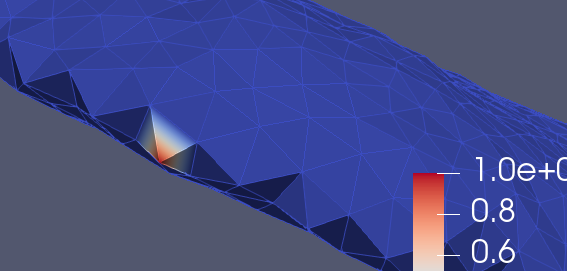

All the corrected ones lose their direction

In [118]:
[np.linalg.eig(Ses_corrected[x])[1] for x in problematic_indices[:5]]

[array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]])]

In [119]:
diff = np.zeros(Ses_org.shape)
reldif = np.zeros((len(v1.indices),2))
for i in v1.indices:
    e_val,e_vec = np.linalg.eig(Ses_org[i])
    e_val2, e_vec2 = np.linalg.eig(Ses_corrected[i])
    diff[i,0] = e_vec[0]@e_vec2[0],e_vec[1]@e_vec2[1]
    diff[i,1]  =e_val-e_val2
    reldif[i] = 1-e_val2/e_val

In [120]:
E1 = np.zeros(v1.indices.shape)
E2 = np.zeros(v1.indices.shape)
for i, vtx in enumerate(ts.iter_xlist(vesicle)):
    vtx_copy=ts.ts_vertex(**{field[0]:vtx.__getattribute__(field[0]) for field in vtx._fields_})
    ts.update_vertex_from_curvature_tensor(ts.pointer(vtx_copy),vtx_copy.area,
                                           *Ses_org[i].flatten(),*v1.normal[i],*v1.director[i],
                                           *np.cross(v1.normal[i],v1.director[i]))
    E1[i] = vtx_copy.energy
    ts.update_vertex_from_curvature_tensor(ts.pointer(vtx_copy),vtx_copy.area,
                                           *Ses_corrected[i].flatten(),*v1.normal[i],*v1.director[i],
                                           *np.cross(v1.normal[i],v1.director[i]))
    E2[i] = vtx_copy.energy

In [156]:
df2=df[["energy difference","eigen vector 1 dot","eigen value 1 difference"]]

In [176]:
df2.columns = ["energy difference between method E_old-E_new","first eigen vector new dot old    ","first eigen value difference"]

In [177]:
df2.describe(percentiles=[0.005,0.01,0.05,0.1,0.9,0.95,0.99,0.995])

,energy difference between method E_old-E_new,first eigen vector new dot old,first eigen value difference
count,2002.000000,2002.000000,2002.000000
mean,1.126362,0.976132,-0.150099
std,8.933436,0.209261,0.401985
min,-29.031752,-0.999990,-2.422325
0.5%,-19.127872,-0.958333,-1.934321
1%,-16.582686,-0.805696,-1.734218
5%,-2.302200,1.000000,-1.041245
10%,-0.559552,1.000000,-0.511627
50%,-0.064388,1.000000,-0.074309
90%,0.014689,1.000000,0.217822


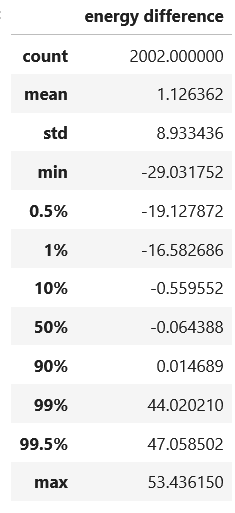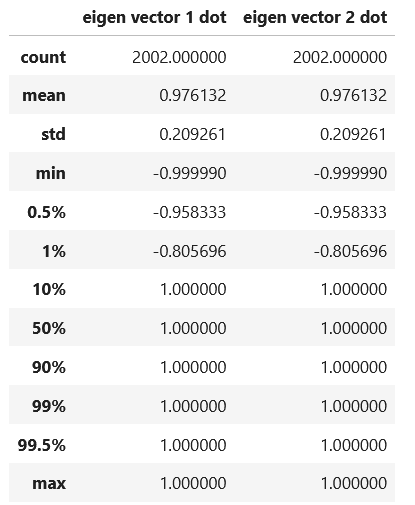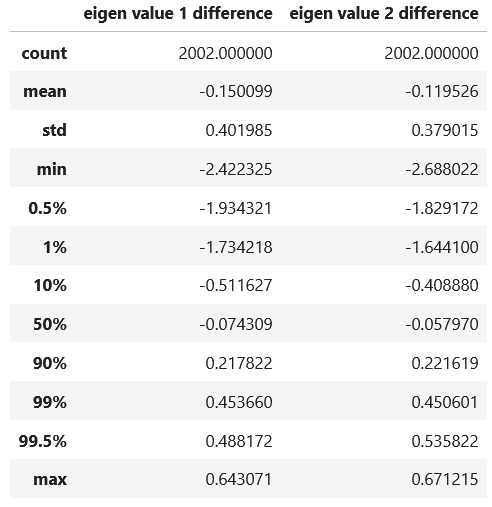

In [121]:
percentiles2 = [0.005,0.01,0.1,0.5,0.9,0.99,0.995]
df = pd.DataFrame({"energy difference": E1-E2,
    "eigen vector 1 dot": diff[:,0,0],
             "eigen vector 2 dot": diff[:,0,1],
             "eigen value 1 difference": diff[:,1,0],
             "eigen value 2 difference": diff[:,1,1],
             "eigen value 1 relative difference": reldif[:,1]})
df.describe(percentiles=percentiles2)

,energy difference,eigen vector 1 dot,eigen vector 2 dot,eigen value 1 difference,eigen value 2 difference,eigen value 1 relative difference
count,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000
mean,1.126362,0.976132,0.976132,-0.150099,-0.119526,-0.605200
std,8.933436,0.209261,0.209261,0.401985,0.379015,87.359536
min,-29.031752,-0.999990,-0.999990,-2.422325,-2.688022,-3438.153817
0.5%,-19.127872,-0.958333,-0.958333,-1.934321,-1.829172,-82.510887
1%,-16.582686,-0.805696,-0.805696,-1.734218,-1.644100,-49.252623
10%,-0.559552,1.000000,1.000000,-0.511627,-0.408880,-2.932865
50%,-0.064388,1.000000,1.000000,-0.074309,-0.057970,0.877189
90%,0.014689,1.000000,1.000000,0.217822,0.221619,4.935275
99%,44.020210,1.000000,1.000000,0.453660,0.450601,36.843369


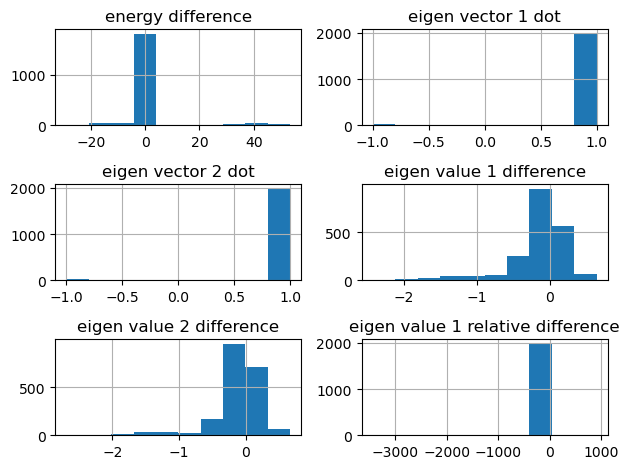

In [122]:
df.hist()
plt.tight_layout()

In [75]:
reldif[reldif.std(axis=1).argsort()[:-10:-1]]

array([[ 1.36203626e+04,  6.90583144e-01],
       [ 8.00631946e-01, -3.19534337e+03],
       [ 7.86623928e-01, -2.48043636e+03],
       [-1.65860251e+03,  9.55018022e-01],
       [ 1.30402263e+03,  1.00004365e+00],
       [ 8.35753683e+02,  9.52944275e-01],
       [-6.14555853e+02,  9.13218786e-01],
       [ 6.50328738e-01, -4.98001144e+02],
       [ 3.92791613e+02,  9.71324841e-01]])

In [135]:
sorted_energy_diff=((E2-E1)**2).argsort()
(E2-E1)[sorted_energy_diff[-150:]]

array([ 12.06755146,  12.11117272,  12.15931148,  12.24435784,
        12.4422508 ,  12.52352853,  13.31669197,  13.84777773,
        13.91658519,  14.09921927,  14.24879984,  14.60167212,
        14.61656653,  14.70146381,  14.84221653,  14.8501037 ,
        15.06299332,  15.15509196,  15.15568622,  15.1903165 ,
        15.29888409,  15.41549005,  15.59360514,  15.61457126,
        15.74176713,  15.89141116,  15.9326164 ,  16.07245121,
        16.07558773,  16.40613435,  16.58446917,  17.05128137,
        17.060917  ,  17.08217922,  17.18800286,  17.29098714,
        17.38150498,  17.69160093,  18.85436872,  19.01511988,
        19.12843886,  19.16239177,  19.40414248,  19.62204105,
        19.68372072, -20.15967814,  20.26451844, -20.31744044,
       -20.61487637, -20.71629497,  20.91503009,  21.00873776,
       -21.16735231, -21.18067325, -21.68158296,  21.7060637 ,
        25.5402515 , -25.67264496, -26.09111154, -26.63645424,
       -26.93244363, -27.22086422, -27.32724369, -27.80

In [150]:
i,j = sorted_energy_diff[[-1,-150]]
i,j

(1823, 1798)

In [140]:
E1[i],E2[i]

(57.95447631652239, 4.5183267703183905)

In [146]:
Ses_org[i],"corrected",Ses_corrected[i]

(array([[-0.88967224,  0.16894985],
        [ 0.16894985, -0.57198362]]),
 'corrected',
 array([[0.84971726, 0.        ],
        [0.        , 0.84971726]]))

In [139]:
np.linalg.eig(Ses_org[i]),"corrected",np.linalg.eig(Ses_corrected[i])

((array([-0.96272352, -0.49893234]),
  array([[-0.91787309, -0.39687403],
         [ 0.39687403, -0.91787309]])),
 'corrected',
 (array([0.84971726, 0.84971726]),
  array([[1., 0.],
         [0., 1.]])))

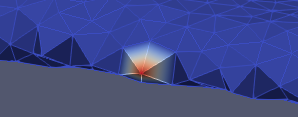

In [147]:
E1[j],E2[j]

(2.5333801673816954, 14.60093162968633)

In [148]:
Ses_org[j],"corrected",Ses_corrected[j]

(array([[-0.38319939, -0.05100817],
        [-0.05100817,  0.04085244]]),
 'corrected',
 array([[-0.38964737, -0.14685766],
        [-0.14685766,  0.83124055]]))

In [149]:
np.linalg.eig(Ses_org[j]),"corrected",np.linalg.eig(Ses_corrected[j])

((array([-0.38924874,  0.04690179]),
  array([[-0.99304085,  0.11777042],
         [-0.11777042, -0.99304085]])),
 'corrected',
 (array([-0.40706406,  0.84865724]),
  array([[-0.99304085,  0.11777042],
         [-0.11777042, -0.99304085]])))

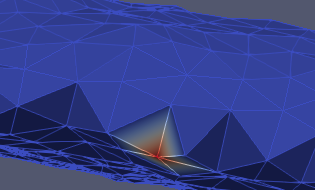

Try to recreate the calculation in python

In [193]:
i=i_good

In [194]:
hkg = (np.trace(Ses[i])**2)-np.linalg.det(Ses[i])
hkg

0.0988505433559435

In [195]:
hkg = (v1.mean_curvature2[i]**2)-v1.gaussian_curvature2[i]
hkg

0.0011106373467797484

In [196]:
hkg = hkg if hkg>0 else 0
h_corr = v1.mean_curvature2[i] if hkg>0 else np.sqrt(v1.gaussian_curvature2[i])
hkg, h_corr

(0.0011106373467797484, 0.17991026564268475)

In [197]:
factor = np.sqrt( hkg*((Ses[i,0,0]-Ses[i,1,1])**2+4*(Ses[i,0,1]**2)) )

In [198]:
Ses[i]

array([[-0.20638759,  0.03394559],
       [ 0.03394559, -0.15322649]])

In [199]:
delta = h_corr-(Ses[i,0,0]+Ses[i,1,1])/2

In [200]:
beta=Ses[i,0,1]*( 2*(-hkg)/factor - 1) if factor!=0 else 0
a = -(
    (Ses[i,0,0]-Ses[i,1,1])*(2*factor+(Ses[i,0,0]-Ses[i,1,1])**2+4*(Ses[i,0,1]**2))
      /( 2*((Ses[i,0,0]-Ses[i,1,1])**2) + 8*(Ses[i,0,1]**2) )
     )

In [201]:
beta2=Ses[i,0,1]*( 2*(hkg)/factor - 1) if factor!=0 else 0
a2 = -(
    (Ses[i,0,0]-Ses[i,1,1])*(-2*factor+(Ses[i,0,0]-Ses[i,1,1])**2+4*(Ses[i,0,1]**2))
      /( 2*((Ses[i,0,0]-Ses[i,1,1])**2) + 8*(Ses[i,0,1]**2) )
     )

In [202]:
a**2+beta**2,a2**2+beta2**2

(0.005843128919122222, 9.580317481714214e-05)

In [225]:
s1=Ses[i]+[[delta+a2,beta2],[beta2,delta-a2]]
s2=Ses[i]+[[delta+a,beta],[beta,delta-a]]
print("using delta, a, and beta\n",s1,"\nusing delta, a2, and beta2\n",s2,"\nactual correction in c\n",Ses3[i])

using delta, a, and beta
 [[0.15936412 0.02623915]
 [0.02623915 0.20045641]] 
using delta, a2, and beta2
 [[ 1.15332972 -0.02623915]
 [-0.02623915 -0.79350919]] 
actual correction in c
 [[0.15936412 0.02623915]
 [0.02623915 0.20045641]]


In [208]:
v1.mean_curvature2[i],np.trace(s1)/2,np.trace(s2)/2,np.trace(Ses3[i])/2

(0.17991026564268475,
 0.17991026564268472,
 0.17991026564268472,
 0.17991026564268472)

In [209]:
v1.gaussian_curvature2[i],np.linalg.det(s1),np.linalg.det(s2),np.linalg.det(Ses3[i])

(0.031257066336841645,
 0.03125706633684163,
 0.03125706633684163,
 0.03125706633684163)

### messy handling of the function directly

In [222]:
mats=np.array([[1.1,1],[1,1]])
h,kg = 1,1
a,b,c = ts.ts_double(mats[0,0]),ts.ts_double(mats[0,1]),ts.ts_double(mats[1,1])
ts.error_correction_scheme(ts.pointer(a),ts.pointer(b),ts.pointer(c),h,kg)
mats2=np.array([[a.value,b.value],[b.value,c.value]])
mats, mats2

(array([[1.1, 1. ],
        [1. , 1. ]]),
 array([[1., 0.],
        [0., 1.]]))

In [230]:
"initial h,kg:",np.trace(mats)/2,np.linalg.det(mats),"corrected h,kg:",np.trace(mats2)/2,np.linalg.det(mats2)

('initial h,kg:', 1.05, 0.10000000000000002, 'corrected h,kg:', 1.0, 1.0)

In [231]:
hkg = h**2-kg
hkg2 = (np.trace(mats)**2)/4-np.linalg.det(mats)
hkg

0

In [232]:
factor = np.sqrt( hkg*( (mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2) ) )
factor

0.0

In [233]:
delta = h-(mats[0,0]+mats[1,1])/2
delta

-0.050000000000000044

In [234]:
beta=-mats[0,1] if factor==0 else mats[0,1]*( 2*(-hkg)/factor - 1)
a = -(
    (mats[0,0]-mats[1,1])*(2*factor+(mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2))
      /( 2*((mats[0,0]-mats[1,1])**2) + 8*(mats[0,1]**2) )
     )

In [235]:
beta,a

(-1.0, -0.050000000000000044)

In [236]:
beta=-mats[0,1] if factor==0 else mats[0,1]*( 2*(hkg)/factor - 1)
a = -(
    (mats[0,0]-mats[1,1])*(-2*factor+(mats[0,0]-mats[1,1])**2+4*(mats[0,1]**2))
      /( 2*((mats[0,0]-mats[1,1])**2) + 8*(mats[0,1]**2) )
     )

In [237]:
beta,a

(-1.0, -0.050000000000000044)

In [238]:
mats+[[delta+a,beta],[beta,delta-a]]

array([[1., 0.],
       [0., 1.]])

## Test curvature

Load the file and the vesicle. Push the vesicle into the PyVtu

In [250]:
fileloc = list(sorted(test_folder.glob('timestep*')))[-1]#[-1]

In [251]:
fileloc

PosixPath('/opt/workspace/msc_project/simulations/QA_tests/cluster_version/rework/egg_carton/linterp/timestep_000099.vtu')

In [295]:
vesicle = ts.parseDump(fileloc)

In [296]:
v = PyVtu(fileloc)
v2 = PyVtu(fileloc) # we will place here the values from vesicle

In [297]:
def iter_xlist(vesiclePtr,xlist_name='vlist',as_pointer=False):
    """Iterate over some vesicle->xlist->xs. Default vesicle->vlist->vtx[:vlist.n]."""
    lst = vesiclePtr.contents.__getattribute__(xlist_name)
    if xlist_name=='vlist':
        n, lst = lst.contents.n, lst.contents.vtx
    elif xlist_name=='clist':
        n, lst = lst.contents.cellno, lst.contents.cell
    elif xlist_name=='tlist':
        n, lst = lst.contents.n, lst.contents.tria
    elif xlist_name=='blist':
        n, lst = lst.contents.n, lst.contents.bond
    else:
        raise ValueError(f'{xlist_name} not in vlist,clist,tlist,blist')
    if as_pointer:
        for i in range(n):
            yield lst[i]
    else:
        for i in range(n):
            yield lst[i].contents

In [298]:
def normbnorm(b):
    n1 = np.array((b.vtx1.contents.nx,b.vtx1.contents.ny,b.vtx1.contents.nz))
    n2 = np.array((b.vtx2.contents.nx,b.vtx2.contents.ny,b.vtx2.contents.nz))
    n = n1+n2
    return n/np.linalg.norm(n)

In [299]:
def replace_pyvtu_values_from_vesicle(v,vesiclePtr):
    """Replace the values the PyVtu arrays with values from the wrapper."""
    blen = vesicle.contents.blist.contents.n
    tlen = vesicle.contents.tlist.contents.n
    v.pos[:] = [(x.x,x.y,x.z) for x in iter_xlist(vesicle)]
    v.add_array('neigh_no',np.array([x.neigh_no for x in iter_xlist(vesicle)]))
    v.c0[:] = [x.c for x in iter_xlist(vesicle)]
    v.e[:] = [x.energy for x in iter_xlist(vesicle)]
    # newer version stuff (can fail but who cares?)
    v.w[:] = [x.w for x in iter_xlist(vesicle)]
    v.f0[:] = [x.f for x in iter_xlist(vesicle)]
    v.face_normal[-tlen:] = np.array([(x.xnorm, x.ynorm, x.znorm) for x in iter_xlist(vesicle,"tlist")])
    v.add_array('normal3',v.normal+0)
    v.normal[:] = [(x.nx,x.ny,x.nz) for x in iter_xlist(vesicle)]
    v.force[:] =[(x.fx,x.fy,x.fz) for x in iter_xlist(vesicle)]
    v.director[:] = [(x.dx,x.dy,x.dz) for x in iter_xlist(vesicle)]
    v.eig0[:] = [x.eig0[:] for x in iter_xlist(vesicle)]
    v.eig1[:] = [x.eig1[:] for x in iter_xlist(vesicle)]
    v.eig2[:] = [x.eig2[:] for x in iter_xlist(vesicle)]
    v.ad_w[:] = [x.ad_w for x in iter_xlist(vesicle)]
    v.type[:] = [ts.byte_to_int(x.type) for x in iter_xlist(vesicle)]
    v.eigenvalue_0[:] = [x.eig_v0 for x in iter_xlist(vesicle)]
    v.eigenvalue_1[:] = [x.eig_v1 for x in iter_xlist(vesicle)]
    v.eigenvalue_2[:] = [x.eig_v2 for x in iter_xlist(vesicle)]
    v.k[:] = [x.xk for x in iter_xlist(vesicle)]
    v.k2[:] = [x.xk2 for x in iter_xlist(vesicle)]
    v.mean_curvature[:] = [x.mean_curvature for x in iter_xlist(vesicle)]
    v.gaussian_curvature[:] = [x.gaussian_curvature for x in iter_xlist(vesicle)]
    v.mean_curvature2[:] = [x.mean_curvature2 for x in iter_xlist(vesicle)]
    v.gaussian_curvature2[:] = [x.gaussian_curvature2 for x in iter_xlist(vesicle)]
    v.add_array('circumcenter',np.array(([(0,0,0)]*blen)+[(x.xcirc,x.ycirc,x.zcirc) for x in iter_xlist(vesicle,'tlist')]),parent='CellData')
    v.add_array('area',np.array([x.area for x in iter_xlist(vesicle)]))
    v.add_array('dSd',np.array([x.S[0] for x in iter_xlist(vesicle)]))
    v.add_array('dSt',np.array([x.S[1] for x in iter_xlist(vesicle)]))
    v.add_array('tSd',np.array([x.S[2] for x in iter_xlist(vesicle)]))
    v.add_array('tSt',np.array([x.S[3] for x in iter_xlist(vesicle)]))
    v.add_array('tangent',np.cross(v.normal,v.director))
    v.add_array('mean_curvature3',v.mean_curvature+0)
    v.add_array('gaussian_curvature3',v.gaussian_curvature+0)
    for i, vtx in enumerate(iter_xlist(vesicle)):
        vtx_copy=ts.ts_vertex(**{field[0]:vtx.__getattribute__(field[0]) for field in vtx._fields_})
        ts.tensor_curvature_energy2(vesicle,ts.pointer(vtx_copy))
        v.mean_curvature3[i]=vtx_copy.mean_curvature
        v.gaussian_curvature3[i]=vtx_copy.gaussian_curvature
        v.normal3[i]=vtx_copy.nx,vtx_copy.ny,vtx_copy.nz

In [300]:
try:
    replace_pyvtu_values_from_vesicle(v2,vesicle)
except AttributeError as e:
    print(f'partial replacement: {e}')

In [301]:
v2.update_all()
v2.write_vtu(str(v2.path).replace('timestep','pystep'))

## Mess about

Check normals are okay

In [302]:
def normalize(x,**kwargs):
    return x/(np.linalg.norm(x,**kwargs))

In [303]:
def perp_bisect(v2,i):
    tposi = v2.pos[v2.tlist[i]]
    circ = v2.circumcenter[6000+i]
    norm = v2.face_normal[6000+i]
    l0,l1,l2 = tposi[1]- tposi[0], tposi[0]- tposi[2], tposi[2]- tposi[1]
    perps = l0/np.linalg.norm(l0),l1/np.linalg.norm(l1),l2/np.linalg.norm(l2)
    perps = [normalize(np.cross(norm,p)) for p in perps]
    m0,m1,m2 = ( tposi[1]+ tposi[0])/2, (tposi[0]+ tposi[2])/2,( tposi[2]+ tposi[1])/2
    return (m0,m1,m2,*perps)

In [304]:
out = []
out2 = []
for i in range(v.tlist.shape[0]):
    m0,m1,m2,p0,p1,p2 = perp_bisect(v2,i)
    circ = v2.circumcenter[6000+i]
    out.append([normalize(m0-circ)@p0,normalize(m1-circ)@p1,normalize(m2-circ)@p2])
    out2.append((v2.pos[v2.tlist[i]]-v2.pos[v2.tlist[i]][[1,2,0]])@v2.face_normal[6000+i])
    
out3 = []
for i in v.indices:
    out3.append(v.director[i]@v.normal[i])

bads = np.where(~np.isclose(out,-1))[0]
bads2 = np.where(~np.isclose(out2,0))[0]
bads3 = np.where(~np.isclose(out3,0))[0]
badness=False
if bads.size>0:
    print(bads)
    print("1st example:",out[bads[0]])
    badness=True
if bads2.size>0:
    print(bads2)
    print("1st example:",out2[bads2[0]])
    badness=True
if bads3.size>0:
    print(bads3)
    print("1st example:", out3[bads3[0]])
    badness=True
if not badness:
    print('all good')

all good


### Print triangles

Notice i is the triangle index!

In [305]:
with_bad_vtx = problematic_values[v2.tlist].any(axis=1)
gen=(x for x in np.arange(len(v2.tlist))[:]) # .tlist))[with_bad_vtx])
i=next(gen)

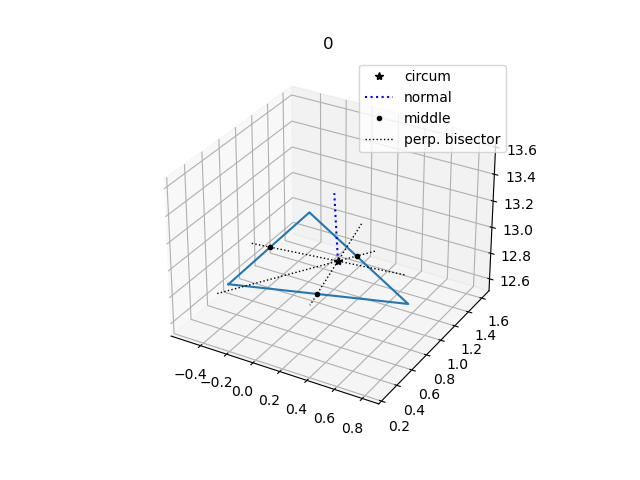

In [306]:
%matplotlib widget

mp = perp_bisect(v2,i)
res = np.array(((v.pos[v.tlist[i]]-v.pos[v.tlist[i]][[1,2,0]])@v.face_normal[6000+i],
               (v2.pos[v2.tlist[i]]-v2.pos[v2.tlist[i]][[1,2,0]])@v2.face_normal[6000+i],
               [mp[3],mp[4],mp[5]]@v.face_normal[6000+i]))
if (np.abs(res)>1e-15).any():
    print("perp. in vtu: ", res[0])
    print("perp. in loaded vesicle: ", res[1])
    print("check perp. bisectors are perpendicular: ",res[2])

ax = plt.figure().add_subplot(projection='3d')
tposi = v2.pos[v2.tlist[i]]
ax.plot(*np.array([tposi[[0,1,2,0]]]).T)
ax.plot(*v2.circumcenter[6000+i],'k*',label='circum')
ax.plot(*np.array((v2.circumcenter[6000+i], 
                   v2.circumcenter[6000+i]-0.5*v2.face_normal[6000+i])).T,
        'b:',label='normal')
ax.plot(*mp[0],'k.',label='middle')
ax.plot(*mp[1],'k.')
ax.plot(*mp[2],'k.')
ax.plot(*np.array((mp[0]+1*mp[3],mp[0]-0.15*mp[3])).T,'k:',linewidth=1,label='perp. bisector')
ax.plot(*np.array((mp[1]+1*mp[4],mp[1]-0.15*mp[4])).T,'k:',linewidth=1)
ax.plot(*np.array((mp[2]+1*mp[5],mp[2]-0.15*mp[5])).T,'k:',linewidth=1)
ax.set_aspect('equal')
ax.set_title(str(i))
ax.legend()
i=next(gen)

In [307]:
%matplotlib inline

### Figure out what's going on in the curvature

In [308]:
df = pd.DataFrame({'H isotropic': v2.mean_curvature2, 'KG isotropic': v2.gaussian_curvature2,
                   'H anisotropic': v2.mean_curvature, 'KG anisotropic': v2.gaussian_curvature,
                   'H lerp': v2.mean_curvature3,'KG lerp': v2.gaussian_curvature3
                  })
df.describe()

,H isotropic,KG isotropic,H anisotropic,KG anisotropic,H lerp,KG lerp
count,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000,2002.000000
mean,0.066859,0.004302,0.066887,0.004302,0.066887,0.004302
std,0.113513,0.030399,0.113683,0.030399,0.113683,0.030399
min,-0.393933,-0.175230,-0.403679,-0.175230,-0.403679,-0.175230
25%,-0.006299,-0.009491,-0.006299,-0.009491,-0.006299,-0.009491
50%,0.069045,-0.000672,0.069045,-0.000672,0.069045,-0.000672
75%,0.139736,0.011847,0.139736,0.011847,0.139736,0.011847
max,0.492393,0.252172,0.502168,0.252172,0.502168,0.252172


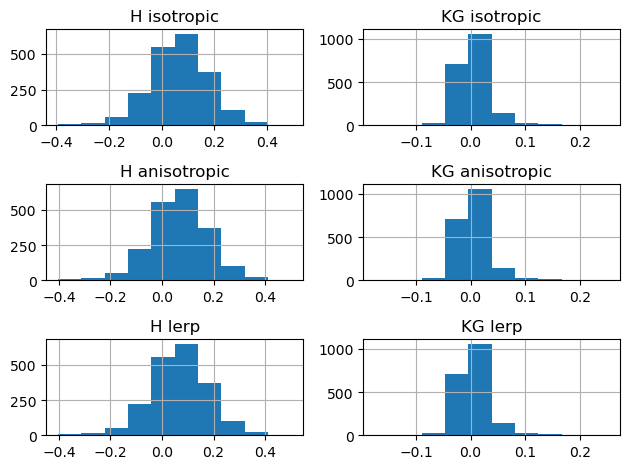

In [309]:
df.hist()
plt.tight_layout()

In [ ]:
fig=plt.figure()
plt.hist(v2.mean_curvature,bins=100)
plt.show()

In [ ]:
S=vtu.reconstruct_shape_operator(v2)

In [ ]:
g=np.stack((v.eig0,v.eig1,v.eig2),axis=1)

In [ ]:
np.einsum("ni,ni->n",v.eig0,v.eig2).mean()

In [ ]:
vtu.reconstruct_shape_operator(v2)[0]

In [ ]:
vtu.reconstruct_shape_operator(v2)[0]

In [ ]:
np.einsum("nij,nkj->nik",g,g)

In [ ]:
s00 = np.einsum("ni,nij,nj->n",v2.director,S,v2.director)
s11 = np.einsum("ni,nij,nj->n",v2.tangent,S,v2.tangent)
s01 = np.einsum("ni,nij,nj->n",v2.director,S,v2.tangent)
s10 = np.einsum("ni,nij,nj->n",v2.tangent,S,v2.director)

In [ ]:
S_diag=np.zeros((v2.indices.shape[0],2,2))
S2=np.zeros((v2.indices.shape[0],2,2))
S_diag[:,0,0]=s00
S_diag[:,1,1]=s11
S2[:,0,0]=s00
S2[:,0,1]=s01
S2[:,1,0]=s10
S2[:,1,1]=s11

In [ ]:
np.trace(S_diag,axis1=1,axis2=2)

In [ ]:
np.trace(S2,axis1=1,axis2=2)

In [ ]:
v2.mean_curvature

In [ ]:
v2.mean_curvature2

In [ ]:
vertices = list(iter_xlist(vesicle,as_pointer=True))

In [ ]:
for i in v.indices[-10:]:
    print(ts.adhesion_geometry_distance(vesicle,vertices[i]))

In [ ]:
vesicle.contents.tape.contents.adhesion_cutoff

In [ ]:
vesicle.contents.tape.contents.mcsweeps

In [ ]:
vesicle.contents.vlist.contents.vtx[2000].contents.z

In [ ]:
# ts.run_simulation(vesicle,1000,0,175,160)

In [ ]:
adhesion_dist = np.array([ts.adhesion_geometry_distance(vesicle,vtx) for vtx in vertices])

In [ ]:
adhesion_dist

In [ ]:
class MongeGauge:

    def __init__(self,x,y,c0,r,z0):
        """Compute monge gauge for h(x,y) = z0+r*cos(x/c0)*cos(y/c0)"""
        self.x=x
        self.y=y
        self.z0=z0
        self.r=r
        self.c0=c0
        self.R = r*np.cos(x/c0)*np.cos(y/c0)+z0
        self.z=self.R
        self.Rx, self.Ry = -r*np.sin(x/c0)*np.cos(y/c0)/c0, -r*np.cos(x/c0)*np.sin(y/c0)/c0
        self.Rxx = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Ryy = r*np.cos(x/c0)*np.cos(y/c0)/(-c0**2)
        self.Rxy = r*np.sin(x/c0)*np.sin(y/c0)/(c0**2)
        self.J = np.array([[1,0,self.Rx],[0,1,self.Ry],[0,0,1]])
        self.e1,self.e2,self.e3 = self.J
        self.g_ab = np.array([[1+self.Rx**2,self.Rx*self.Ry],
                              [self.Rx*self.Ry,1+self.Ry**2]])
        self.g = 1+self.Rx**2+self.Ry**2
        self.sqrtg = (self.g**0.5)
        self.gab = np.array([[1+self.Ry**2,-self.Rx*self.Ry],
                             [-self.Rx*self.Ry,1+self.Rx**2]])/self.g
        self.n = np.array([-self.Rx,-self.Ry,1])/self.sqrtg
        self.K_ab = np.array([[self.Rxx,self.Rxy],
                              [self.Rxy,self.Ryy]])/self.sqrtg
        self.Sa_b = self.K_ab@self.gab
        self.w,self.v = np.linalg.eig(self.Sa_b)
        self.vxyz = self.v.T@self.J[:2]
        self.H, self.KG = self.Sa_b.trace()/2, np.linalg.det(self.Sa_b)
        self.xyzFromab = np.array([self.e1,self.e2])
        self.Jinv = np.linalg.inv(self.J)



In [ ]:
def expected_curvature(vesicle,vtx):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    x,y,z = vtx.contents.x, vtx.contents.y, vtx.contents.z
    # Monge Gauge
    return MongeGauge(x,y,c0,r,z0)
    

In [ ]:
r = vesicle.contents.tape.contents.adhesion_radius
c0 = vesicle.contents.tape.contents.adhesion_scale
z0 = vesicle.contents.tape.contents.adhesion_z

In [ ]:
def press_vertices_to_shape(vesicle):
    r = vesicle.contents.tape.contents.adhesion_radius
    c0 = vesicle.contents.tape.contents.adhesion_scale
    z0 = vesicle.contents.tape.contents.adhesion_z
    for vtx in iter_xlist(vesicle3,as_pointer=True):
        if dz:=ts.adhesion_geometry_distance(vesicle,vtx)<0.5:
            vtx.contents.z = z0+r*np.cos(vtx.contents.x/c0)*np.cos(vtx.contents.y/c0)
    ts.init_normal_vectors(vesicle.contents.tlist)
    ts.sweep_vertex_curvature_energy(vesicle)


In [ ]:
v3 = PyVtu(v2.path)
vesicle3 = ts.parseDump(v3.path)
press_vertices_to_shape(vesicle3)
replace_pyvtu_values_from_vesicle(v3,vesicle3)

In [ ]:
adhesion_dist2 = np.array([ts.adhesion_geometry_distance(vesicle3,vtx) for vtx in iter_xlist(vesicle3,as_pointer=True)])
adhesion_dist2[-20:]

In [ ]:
v3.update_all()
v3.write_vtu(str(v3.path).replace('timestep','flattened_pystep'))

In [ ]:
Svs = vtu.reconstruct_shape_operator(v3)
gs = np.stack((v3.eig0,v3.eig1,v3.eig2),axis=1)

In [ ]:
i=1950

In [ ]:
i+=1

In [ ]:
mg=expected_curvature(vesicle,vertices[i])

In [ ]:
2*mg.H, mg.KG

In [ ]:
('tensor:',v3.mean_curvature[i],v3.gaussian_curvature[i]),('debug: ',v3.mean_curvature2[i],v3.gaussian_curvature2[i])

In [ ]:
gs[i], Svs[i]

In [ ]:
Sx_y=np.einsum("ab,bi,aj->ij",mg.Sa_b,mg.J[:2,:],mg.J[:2,:])
Sx_y

In [ ]:
mg.w,mg.vxyz

In [ ]:
v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eig0[i],v3.eig1[i]

In [ ]:
def square_comp(x,y,z,v0,v1,v2,e0,e1,e2):
    xy=np.linspace(-1,1,10)
    XY=np.array(np.meshgrid(xy,xy))
    E0, E1 = np.einsum("ix,xnm->inm",np.array((e0,e1))[:,:2],XY)
    E2 = 0.5*v0*E0**2 + 0.5*v2*E1**2
    X,Y,Z = np.einsum("xi,inm->xnm",np.linalg.inv(np.array((e0,e1,e2))),np.array((E0,E1,E2)))
    return X+x,Y+y,Z+z
    

In [ ]:
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
dist = ((v3.pos-v3.pos[i])**2).sum(axis=1)**0.5
in_dist = dist<5
x, y = np.linspace(tuple(v3.pos[in_dist,:2].min(axis=0)),tuple(v3.pos[in_dist,:2].max(axis=0)),20).T
X,Y = np.meshgrid(x,y)
Z = z0+r*np.cos(X/c0)*np.cos(Y/c0)
ax.plot_wireframe(X,Y,Z,linewidths=0.5)
X,Y,Z = square_comp(*v3.pos[i],v3.eigenvalue_0[i],v3.eigenvalue_1[i],v3.eigenvalue_2[i],v3.eig0[i],v3.eig1[i],v3.eig2[i])
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='g')
X,Y,Z = square_comp(*v3.pos[i],*mg.w,0,*mg.vxyz,mg.n)
ax.plot_wireframe(X,Y,Z,linewidths=0.5,color='r')
ax.plot(*v3.pos[in_dist].T,'.k',markersize=1)
ax.plot(*v3.pos[i],'*')
ax.plot(*v3.pos[v3.get_ordered_neighbors(v3.indices[i])].T,'*')
ax.set_aspect('equal')
ax.set_title(f'{i}')

In [ ]:
plt.close()

# and now for something completely different

In [ ]:
def plotMySurf(axe3D, *, points=None, p_dict=None, bonds=None, b_dict=None,
               triangles=None, t_dict=None, reaspect=None, **fmt_dict):
    """Plot a surface with points and bonds.

    points: nx3
    p_dict: {color: 'k', 'linestyle':'None', 'marker'='.', 'linewidth': 0.4}
    bonds: mx2
    b_dict: {'color': 'k', 'linestyle': '-',
             'marker': 'None', 'linewidth': 0.25}
    """
    if points is not None:
        if p_dict is None:
            p_dict = {'color': 'k',
                      'linestyle': 'None', 'marker': '.',
                      'linewidth': 0.2, }#'markersize': 2}
        p_dict.update(fmt_dict)
        x, y, z = np.vstack((points, np.ones(3)*np.nan)).T
        axe3D.scatter3D(x[:-1], y[:-1], z[:-1], **p_dict)
        if reaspect:
            reaspectAxe(axe3D, points)
    if bonds is not None:
        edges = np.hstack((bonds,
                           np.ones((bonds.shape[0], 1), dtype=int)*(len(x)-1))
                          ).flatten()
        if b_dict is None:
            b_dict = {'color': 'k', 'linestyle': '-',
                      'marker': 'None', 'linewidth': 0.25}
        b_dict.update(fmt_dict)
        if type(b_dict['color']) is np.ndarray:
            if b_dict['color'].size>4.:
                b_dict['color']=b_dict['color'].mean(axis=0)
        xen, yen, zen = x[edges], y[edges], z[edges]
        axe3D.plot3D(xen, yen, zen, **b_dict)

In [ ]:
def color_for(_type, lbl=None):
    """Color function for clusters."""
    c_bare = (0.9, 0.9, 0.9, 1.0)
    c_conv = plt.cm.tab20b(13)
    c_conc = plt.cm.tab20c(1)
    try:
        c = (
             (_type[:, np.newaxis] == 5)*c_conc
             + (_type[:, np.newaxis] == 47)*c_conv
             + (_type[:, np.newaxis] == 4)*c_bare
            )
    except (IndexError, TypeError):
        c = {5: c_conc, 47: c_conv}.get(_type, c_bare)
    return c


In [ ]:
def fit_coolwarm(array,minval=None,maxval=None):
    if minval is None:
        minval=min(array)
    if maxval is None:
        maxval=max(array)
    if minval==maxval:
        return plt.cm.coolwarm(array)
    carray = (array-minval)/(maxval-minval)
    return plt.cm.coolwarm(carray)

In [ ]:
color2 = fit_coolwarm(v3.mean_curvature,-1,1)
color2

In [ ]:
color2[v3.blist].mean(axis=1)

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
plotMySurf(axe,points=v3.pos,p_dict={'color': color2,'s':0.5},
           bonds=v.blist,b_dict={'color': color2[v3.blist].mean(axis=1)})

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.plot(*v3.pos.T,'.',color='k',markersize=0.5)

In [ ]:
def refine_mesh_once(v):
    """Create x,y,z and tlist of a refined mesh.

    Every bond in the original mesh is now another vertex with index
    of number original vertices + number of the original bond
    """
    x,y,z = v.pos.T
    tlist = v.tlist
    blist = v.blist
    nvtx = len(x)
    nb = len(blist)
    nt = len(tlist)
    x2,y2,z2 = np.zeros((3,nvtx+nb))
    x2[:nvtx],y2[:nvtx],z2[:nvtx] = x,y,z
    x2[nvtx:],y2[nvtx:],z2[nvtx:] = v.pos[v.blist].mean(axis=1).T
    tlist2 = np.zeros((4*nt,3),dtype=int)
    # blist2 = np.zeros((3*nt//2,2),dtype=int)
    for i,t in enumerate(tlist):
        a,b,c = t
        ab=nvtx+np.where((blist==(a,b)).all(1)|(blist==(b,a)).all(1))[0][0]
        bc=nvtx+np.where((blist==(b,c)).all(1)|(blist==(c,b)).all(1))[0][0]
        ca=nvtx+np.where((blist==(c,a)).all(1)|(blist==(a,c)).all(1))[0][0]
        tlist2[4*i:4*(i+1),:]=((a,ab,ca),(b,bc,ab),(c,ca,bc),(ab,bc,ca))
    return x2,y2,z2,tlist2


In [ ]:
x2,y2,z2,tlist2 = refine_mesh_once(v2)

In [ ]:
types = np.concatenate((v2.type,v2.type[v2.blist].sum(axis=1)/2))
c_tri = fit_coolwarm(types[tlist2].sum(axis=1)/3)#,4-47,47)

In [ ]:
poly3=Poly3DCollection(verts=np.stack((x2[tlist2],y2[tlist2],z2[tlist2]),axis=-1),
                       facecolor=c_tri,edgecolor='k',linewidth=0.1)
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(x2,y2,z2)

In [ ]:
tri=plt.matplotlib.tri.Triangulation(*v.pos[:,:2].T)
ref = plt.matplotlib.tri.UniformTriRefiner(tri)
tri2, z2=ref.refine_field(v.pos[:,2])
tri3, c2=ref.refine_field(v.c0)

In [ ]:
color_ref = plt.cm.coolwarm(np.array((*c2,-1,1)))[:-2]

In [ ]:
triangles = tri2.get_masked_triangles()
xt = tri2.x[triangles]
yt = tri2.y[triangles]
zt = z2[triangles]
verts = np.stack((xt, yt, zt), axis=-1)
cs = color_ref[triangles].mean(axis=1)

In [ ]:
poly3=Poly3DCollection(verts=verts,facecolor=cs)
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(xt,yt,zt)

In [ ]:
tricol=color2[v3.tlist].mean(axis=1)

In [ ]:
v.tlist

In [ ]:
tricol

In [ ]:
poly3=Poly3DCollection(verts=v.pos[v.tlist],facecolor=tricol)

In [ ]:
poly3

In [ ]:
v.pos[v.tlist]

In [ ]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.add_collection3d(poly3)
axe.auto_scale_xyz(*v3.pos.T)